# Определение перспективного тарифа для телеком-компании
  **Цель Исследования**

**Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.**

Оператор всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

## Импорт и исследование данных

Импортируем датасеты, при исследовании и оценке важно помнить, что оператор всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Ннеиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

In [1]:
from scipy import stats as st
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

In [2]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [3]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

In [4]:
df_calls.info()
df_calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [5]:
df_calls.user_id.value_counts().count()

492

**Таблица calls (информация о звонках):
id — уникальный номер звонка
call_date — дата звонка
duration — длительность звонка в минутах
user_id — идентификатор пользователя, сделавшего звонок**


данные в call_date необходимо привести к формату datetime, duration округлить в сторону большего целого числа

In [6]:
df_calls.duration =np.ceil(df_calls['duration'])#.map(lambda x: math.ceil(x))
df_calls.call_date = pd.to_datetime(df_calls.call_date)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


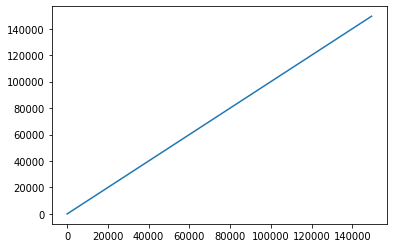

In [7]:
df_internet.info()
df_internet['Unnamed: 0'].plot()
df_internet.head()

**Таблица internet (информация об интернет-сессиях):
id — уникальный номер сессии
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
session_date — дата интернет-сессии
user_id — идентификатор пользователя**

данные в session_date необходимо преобразовать в datetime.
есть столбец "Unnamed: 0" данные в котором дублируют индекс таблицы, его необходимо удалить

In [8]:
df_internet = df_internet.drop(columns='Unnamed: 0')
df_internet.session_date = pd.to_datetime(df_internet.session_date)

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

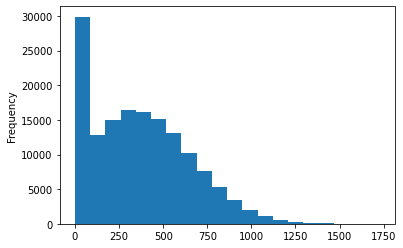

In [9]:
df_internet['mb_used'].plot(kind='hist', bins=20)
df_internet['mb_used'].describe()

In [10]:
df_messages.info()
df_messages.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


**message_date преобразовать в datetime формат**

In [11]:
df_messages.message_date = pd.to_datetime(df_messages.message_date)

In [12]:
df_users.info()
df_users.user_id.duplicated().sum()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


**churn_date и reg_date преобразовать в datetime** 
есть 38 абонентов, которые отказались от своих тарифных планов в течении 2018 года.

In [13]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], errors='coerce')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])

In [14]:
df_tariffs.info()
df_tariffs= df_tariffs.rename(columns={'tariff_name' : 'tariff'})
df_tariffs ['gb_included'] = df_tariffs['mb_per_month_included'].map(lambda x: x/1024)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [15]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


    Я проанализировал 5 датафреймов, во всех выявлено нессответствие формату дата время в столбцах с датой и временем, 
    данные приведены к соответствующим форматам
    
    В df_internet обнаружен столбец с дублированием индекса, данный столбец был удален из датафрейма.
    
    В df_calls мы привели значения из duration к целочисленному формату с округлением в большую сторону, так как логика
    биллинга оператора предусматривает именно такой подсчет полных минут соединения. Также есть ряд звонков со значением 0,
    по ним очевидно не зафиксировано факта соединения, поэтому звонок не тарифицировался
    
    в df_tariffs переименован столбец с названием тарифа из tariff_name в tariff для удобства дальнейшей работы.
    
    
    
    

## Посчитайте для каждого пользователя:
    количество сделанных звонков и израсходованных минут разговора по месяцам;
    
    количество отправленных сообщений по месяцам;
    
    объем израсходованного интернет-трафика по месяцам;
    
    помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и 
    интернет-трафика; 
    
    остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [16]:
#посчитаем количество звонков и минут по месяцам
df_calls['month'] = df_calls['call_date'].dt.month
month_calls = df_calls.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'duration':'month_calls_duration','id':'calls_per_month'})
month_calls.columns = month_calls.columns.map(''.join)
month_calls.head()

,user_id,month,month_calls_duration,calls_per_month
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58


In [17]:
#посчитаем количество сообщений в месяц для каждого пользователя
df_messages['month'] = df_messages['message_date'].dt.month
month_messages = df_messages.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id':'sms_per_month'})
month_messages.columns = month_messages.columns.map(''.join)
month_messages.head()

,user_id,month,sms_per_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [18]:
#посчитаем обьем трафика в месяц для каждого пользователя.
df_internet['month'] = df_internet['session_date'].dt.month
month_internet = df_internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns={'mb_used':'mb_per_month'})
month_internet.columns = month_internet.columns.map(''.join)
month_internet.head()

,user_id,month,mb_per_month
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [19]:
#посчитаем интернет трафик в гигабайтах в месяц. 
#Согласно условиям тарификации, мы округляем не отдельные сессии, а общий обьем трафика в месяц
month_internet['gb_per_month'] = month_internet['mb_per_month'].map(lambda x: math.ceil(x / 1024))
month_internet.head()

,user_id,month,mb_per_month,gb_per_month
0,1000,5,2253.49,3
1,1000,6,23233.77,23
2,1000,7,14003.64,14
3,1000,8,14055.93,14
4,1000,9,14568.91,15


In [20]:
#Обьединим наши сводные таблицы с помесячным расчетом обьема услуг с данными о абонентах и тарифных планах
data = month_calls.merge(month_messages, on=['user_id', 'month'], how='outer')
data = data.merge(month_internet, on=['user_id', 'month'], how='outer')
data = data.merge(df_users, on='user_id', how='outer')
data = data.merge(df_tariffs, on='tariff', how='left')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   float64       
 2   month_calls_duration   3174 non-null   float64       
 3   calls_per_month        3174 non-null   float64       
 4   sms_per_month          2717 non-null   float64       
 5   mb_per_month           3203 non-null   float64       
 6   gb_per_month           3203 non-null   float64       
 7   age                    3216 non-null   int64         
 8   churn_date             189 non-null    datetime64[ns]
 9   city                   3216 non-null   object        
 10  first_name             3216 non-null   object        
 11  last_name              3216 non-null   object        
 12  reg_date               3216 non-null   datetime64[ns]
 13  tar

,user_id,month,month_calls_duration,calls_per_month,sms_per_month,mb_per_month,gb_per_month,age,churn_date,city,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_included
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0


In [21]:
data.duplicated().sum()

0

Мы провели обьединение таблиц с данными о звонках, смс, потребляемом трафике с данными о пользователях и о тарифах.
В итоговой таблице получилось 

In [22]:
#создадим функцию для подсчета расхода абонентов на услуги
def expences(row):
    #создадим переменные для подсчета превышения лимита испотльзования услуг связи и интернет
    calls_above = row['month_calls_duration'] - row['minutes_included']
    sms_above = row['sms_per_month'] - row['messages_included']
    internet_above = row['gb_per_month'] - row['gb_included']
    #посчитаем стоимость услуг сверх тарифа
    calls_exp = calls_above * row['rub_per_minute'] if calls_above > 0 else 0
    sms_exp = sms_above * row['rub_per_message'] if sms_above > 0 else 0
    internet_exp = internet_above * row['rub_per_gb'] if internet_above > 0 else 0
    return row['rub_monthly_fee'] + calls_exp + sms_exp + internet_exp

In [23]:
#добавим столбец с общим обьемом расходов абонента в месяц
data['expenses'] = data.apply(lambda x: expences(x), axis=1)
data.head()
data

,user_id,month,month_calls_duration,calls_per_month,sms_per_month,mb_per_month,gb_per_month,age,churn_date,city,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_included,expenses
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,19559.44,20.0,35,NaT,Санкт-Петербург,...,smart,50,15360,500,550,200,3,3,15.0,1550.0
3212,1489,11.0,NaN,NaN,20.0,17491.56,18.0,35,NaT,Санкт-Петербург,...,smart,50,15360,500,550,200,3,3,15.0,1150.0
3213,1489,12.0,NaN,NaN,35.0,17322.51,17.0,35,NaT,Санкт-Петербург,...,smart,50,15360,500,550,200,3,3,15.0,950.0
3214,1128,NaN,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0


## Анализ данных
    - Опишите поведение клиентов оператора, исходя из выборки
    - Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа
    в месяц? 
    - Посчитайте среднее количество, дисперсию и стандартное отклонение
    - Постройте гистограммы. Опишите распределения


(0.0, 7000.0)

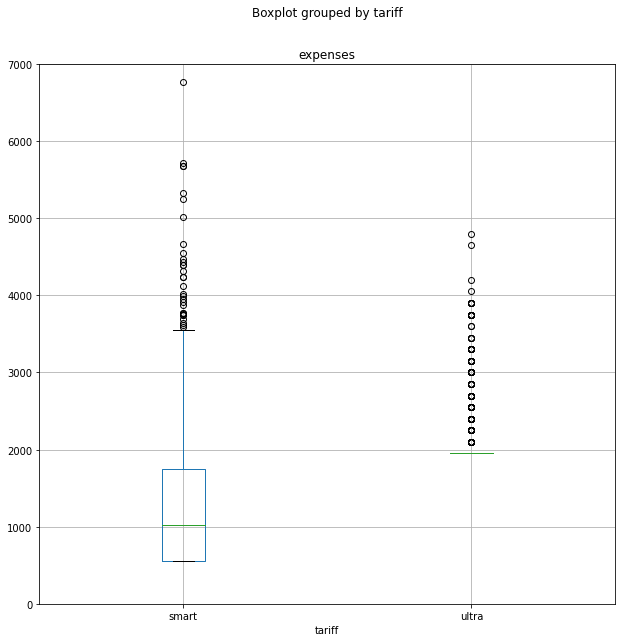

In [24]:
#оценим расходы абонентов в зависимости от тарифного плана
data.boxplot('expenses', by='tariff', figsize=(10,10)).set_ylim(0,7000)

<AxesSubplot:ylabel='Frequency'>

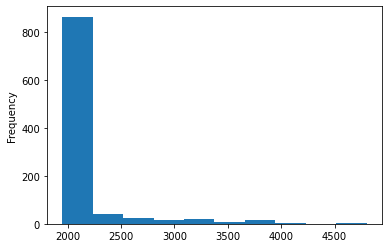

In [25]:
data[data['tariff'] == 'ultra']['expenses'].plot(kind='hist', bins=10)

<AxesSubplot:ylabel='Frequency'>

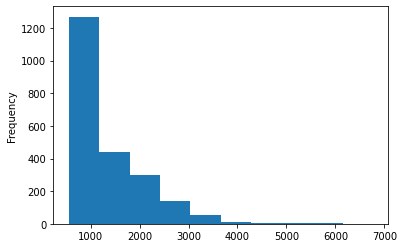

In [26]:
data[data['tariff'] == 'smart']['expenses'].plot(kind='hist', bins=10)

In [27]:
data.groupby('tariff')\
  .agg({'expenses':['median','mean','var','std']})\
  .style.format("{:.2f}")

**Из графиков можно сделать вывод, что абоненты тарифа ультра в массе своей не превышают лимиты по трафику минутам и смс**

Text(0.5, 1.0, 'Смарт — Звонки в минутах в месяц')

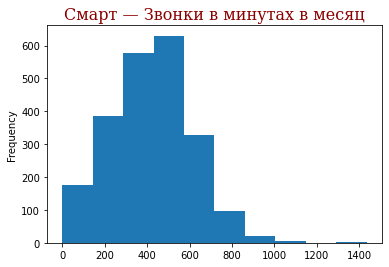

In [28]:
data[data['tariff'] == 'smart']['month_calls_duration'].plot(kind='hist', bins=10)
plt.title('Смарт — Звонки в минутах в месяц',fontdict=font)

Text(0.5, 1.0, 'Ультра — Звонки в минутах в месяц')

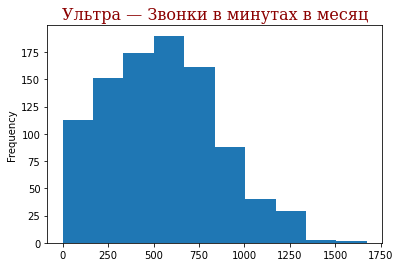

In [29]:
data[data['tariff'] == 'ultra']['month_calls_duration'].plot(kind='hist', bins=10)
plt.title('Ультра — Звонки в минутах в месяц', fontdict=font)

    На Смарте люди в месяц говорят около 450 минут, на Ультре 550 минут в месяц. Абоненты тарифа Ультра имеют большой запас неизрасходованных минут, вто время как абоненты Смарт используют его по максимуму.

In [30]:
data.groupby('tariff')\
  .agg({'gb_per_month':['median','mean','std']})\
  .style.format("{:.2f}")

Text(0.5, 1.0, 'Смарт — Интернет в ГБ в месяц')

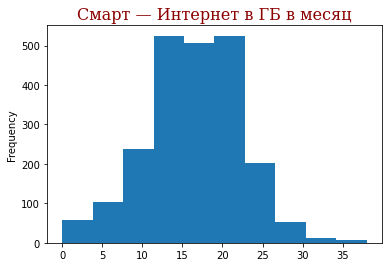

In [31]:
data[data['tariff'] == 'smart']['gb_per_month'].plot(kind='hist', bins=10)
plt.title('Смарт — Интернет в ГБ в месяц', fontdict=font)

Text(0.5, 1.0, 'Ультра — Интернет в ГБ в месяц')

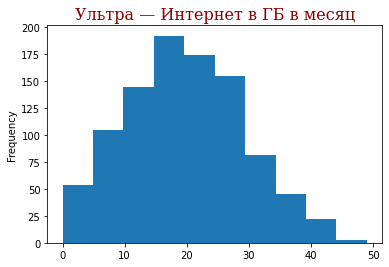

In [32]:
data[data['tariff'] == 'ultra']['gb_per_month'].plot(kind='hist', bins=10)
plt.title('Ультра — Интернет в ГБ в месяц', fontdict=font)

    Среднее и медиана лежат рядом. На Смарте люди выходят за пределы тарифа больше, у Ультры снова запас — в 10-11 Гб, но и разброс больше

In [33]:
data.groupby('tariff')\
  .agg({'sms_per_month':['median','mean','var','std']})\
  .style.format("{:.2f}")

Text(0.5, 1.0, 'Смарт — СМС в месяц')

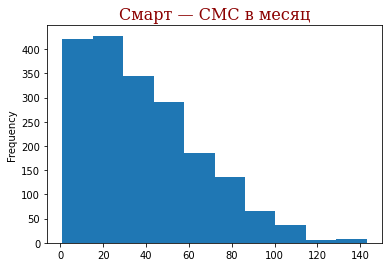

In [34]:
data[data['tariff'] == 'smart']['sms_per_month'].plot(kind='hist', bins=10)
plt.title('Смарт — СМС в месяц', fontdict=font)

Text(0.5, 1.0, 'Ультра — СМС в месяц')

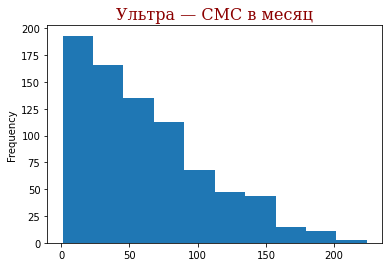

In [35]:
data[data['tariff'] == 'ultra']['sms_per_month'].plot(kind='hist', bins=10)
plt.title('Ультра — СМС в месяц', fontdict=font)

Использование СМС практически одинаково в обоих случаях, но на Ультра включено 1000 сообщений в месяц, что кажется излишним

## Проверьте гипотезы
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Будем использовать t-критерий Стьюдента, так как сравниваемые выборки независимы между собой.

Гипотеза о равенстве средних двух генеральных совокупностей №1

**Сформулируем гипотезы:**

    H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается
    H1: выручка пользователей тарифов «Ультра» и «Смарт» различается

In [36]:
data.head(5)

,user_id,month,month_calls_duration,calls_per_month,sms_per_month,mb_per_month,gb_per_month,age,churn_date,city,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_included,expenses
0,1000,5.0,159.0,22.0,22.0,2253.49,3.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
1,1000,6.0,172.0,43.0,60.0,23233.77,23.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
2,1000,7.0,340.0,47.0,75.0,14003.64,14.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
3,1000,8.0,408.0,52.0,81.0,14055.93,14.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0
4,1000,9.0,466.0,58.0,57.0,14568.91,15.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,1950.0


In [37]:
ultra = data[data['tariff'] == 'smart']['expenses']
smart = data[data['tariff'] == 'ultra']['expenses']

In [38]:
#значение alpha зададим как 0,05
alpha = 0.05

In [39]:
results = st.ttest_ind(ultra, smart, equal_var = False)

In [40]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


    Разница не случайна, есть значимые различия между выборками

**Гипотеза о равенстве средних двух генеральных совокупностей №2**

    Сформулируем гипотезы:

- H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [41]:
data['region'] = np.where(data['city'] == 'Москва', 'Москва', 'Провинция')

In [42]:
moscow = data[data['region'] == 'Москва']
province = data[data['region'] == 'Провинция']

In [43]:
moscow = moscow['expenses']
province = province['expenses']

In [44]:
results = st.ttest_ind(moscow, province, equal_var = False)

In [45]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5216952110000279
Не получилось отвергнуть нулевую гипотезу


    Вывод
    
    Нулевая гипотеза (средние выручки клиентов тарифов «Ультра» и «Смарт» равны) отвергнута. Верна альтернативная гипотеза — средние выручки клиентов тарифов «Ультра» и «Смарт» отличаются с вероятностью почти более 99 %.
    
    Нулевая гипотеза (средняя выручка клиентов из Москвы и других регионов равны) верна с вероятностью почти 56 %.

## Выводы


Люди на разных тарифах ведут себя по-разному

СМС-ки никому не нужны на обоих тарифах. Но если в Смарте люди близки к своим лимитам, то на Ультре остаются большие неизрасходованные "запасы"

Деньги одинаково текут и из регионов и из Москвы, и вероятно это не связано с уровнем жизни, а с поведением: ~8-10 часов в месяц — это предел у среднего клиента на обоих тарифах

Тарифы приносят разные деньги, значимые различия есть

Абоненты ультра чаще превышают лимиты звонков и интернет, что приводит к большему притоку денег для оператора, так как трафик сверх тарифа стоит дороже чем включенный в пакет.


Text(0, 0.5, 'Рубли')

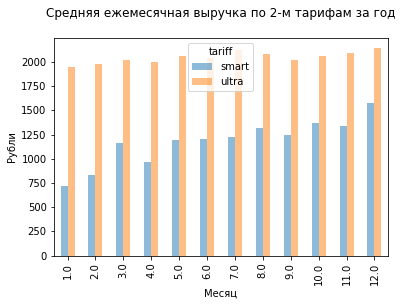

In [46]:
#Сравнение средних значений
data.pivot_table(index='tariff', columns='month', values='expenses', aggfunc='mean').T.plot(kind='bar', alpha=0.5)
plt.title('Средняя ежемесячная выручка по 2-м тарифам за год'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли')